# PROBLEM 1

Let's go over the important parts of the example code. You an go over the documantation if you want to deepen you understanding in how JAX library 
works. 


In [31]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.flatten_util import ravel_pytree

from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from pandas import read_csv
import numpy as onp
from sklearn.metrics import confusion_matrix
from jax.nn import sigmoid
import itertools
from jax.experimental import optimizers


(2500,)





  0%|          | 0/100 [00:00<?, ?it/s]

{'weights': DeviceArray([-0.7847661,  0.8564447], dtype=float32), 'noise_logvar': -4.0}
{'noise_logvar': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'weights': Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=0/1)>}
{'noise_logvar': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'weights': Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=0/1)>}
{'noise_logvar': Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>, 'weights': Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=0/1)>}





  0%|          | 0/100 [00:00<?, ?it/s, Loss=704.93243]


  1%|          | 1/100 [00:00<01:34,  1.05it/s, Loss=704.93243]


  1%|          | 1/100 [00:01<01:34,  1.05it/s, Loss=345.12122]


  1%|          | 1/100 [00:01<01:34,  1.05it/s, Loss=250.8764] 


  3%|▎         | 3/100 [00:01<01:06,  1.47it/s, Loss=250.8764]


  3%|▎         | 3/100 [00:01<01:06,  1.47it/s, Loss=159.05197]


  3%|▎         | 3/100 [00:01<01:06,  1.47it/s, Loss=133.98618]


  5%|▌         | 5/100 [00:01<00:46,  2.02it/s, Loss=133.98618]


  5%|▌         | 5/100 [00:01<00:46,  2.02it/s, Loss=155.88461]


  5%|▌         | 5/100 [00:01<00:46,  2.02it/s, Loss=197.29318]


  7%|▋         | 7/100 [00:01<00:33,  2.75it/s, Loss=197.29318]


  7%|▋         | 7/100 [00:01<00:33,  2.75it/s, Loss=124.32219]


  7%|▋         | 7/100 [00:01<00:33,  2.75it/s, Loss=105.319626]


  9%|▉         | 9/100 [00:01<00:24,  3.69it/s, Loss=105.319626]


  9%|▉         | 9/100 [00:01<00:24,  3.69it/s, Loss=105.42265] 


  9%|▉       

{'noise_logvar': DeviceArray(-0.29949695, dtype=float32), 'weights': DeviceArray([0.65800494, 1.672816  ], dtype=float32)}


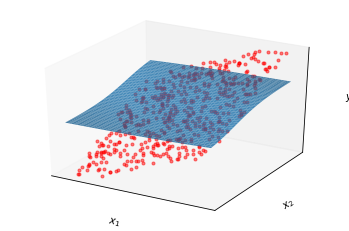

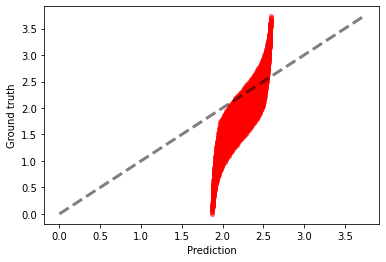

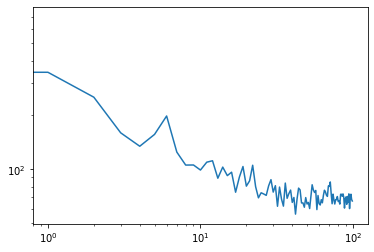

In [13]:

class SGD():
  def __init__(self, learning_rate = 1e-3):
    self.learning_rate = learning_rate

  def step(self, params, grad):
    # This line ravels (flattens) teh dictionary, such that it has a vector like
    # form.
    params_flat, unravel = ravel_pytree(params)
    # We do the same thing for the gradient.
    grad_flat, _ = ravel_pytree(grad)
    params_flat = params_flat - self.learning_rate*grad_flat
    return unravel(params_flat)

class LinearRegression():
  def __init__(self, X, y, rng_key):
    # Normalize data
    self.Xmean, self.Xstd = X.mean(0), X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)
    X = (X - self.Xmean)/self.Xstd
    y = (y - self.Ymean)/self.Ystd

    # Store the normalized trainind data
    self.X = X
    self.y = y
    self.dim = X.shape[1]

    # Initialize the linear regression model
    self.init, self.apply = self.init_linear_regression(self.dim)
    self.params = self.init(rng_key)
    print(self.params)
    # Create optimizer
    self.optimizer = SGD(learning_rate=1e-4)

    # Logger to monitor the loss function
    self.loss_log = []


  def init_linear_regression(self, dim):
    def _init(rng_key):
      w = random.normal(rng_key, (dim,))
      logsigma = -4.0 # Tip: use sigma = np.exp(logsigma) to constrain sigma to be positive!
      # Create a parameter dictionary
      params = {'weights': w, 'noise_logvar': logsigma}
      return params
    def _apply(params, input):
      w = params['weights']
      # Apply the step to find the output.
      out = sigmoid(np.dot(input, w))
      return out
    return _init, _apply


  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    # Use the features or inputs to get the prediction for the particular data 
    # point.
    y_pred = self.apply(params, X)
    sigma_sq = np.exp(params['noise_logvar'])
    # Find the likelihood for each data point.
    loss = 0.5*np.log(2.0*np.pi*sigma_sq) + \
           0.5*(y - y_pred)**2/sigma_sq
    return loss

  def loss(self, params, batch):
    # We are using a lambda function here such that we can more easily vectorize
    # the per example loss.
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    # Using vmap get the solution for all the batch points and then take their
    # sum to calculate the loss.
    loss = np.sum(vmap(pe_loss)(batch))
    return loss

  # The decorator here is used to jit compile this function, such that we get 
  # a speed up. The static argument here is in order to inform the interpreter
  # to consider self as a static argument or else it will not be able to get 
  # interpreted.
  @partial(jit, static_argnums=(0,))
  def step(self, params, batch):
    g = grad(self.loss, 0)(params, batch)
    print(g)
    params = self.optimizer.step(params, g)
    return params

  # Function that returns an iterable object which fetches random batches.
  def data_stream(self, n, num_batches, batch_size):
    # Select different random keys.
    rng = npr.RandomState(0)
    while True:
      # Randomly permute data
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    # You need to find out how many batches exist in the dataset and 
    # how many leftover data.
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    params = self.params
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        params = self.step(params, batch)
      self.params = params
      loss_value = self.loss(params, batch)
      self.loss_log.append(np.abs(loss_value))
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    X_star = (X_star - self.Xmean)/self.Xstd
    pred_fn = lambda x: self.apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred


def f(x):
  x1, x2 = x[0], x[1]
  y = np.sqrt(3.0)*x1 + 2.0*x2
  return y


rng_key = random.PRNGKey(0)

d = 2
n = 500
noise = 0.1

# Create training data
X = random.uniform(rng_key, (n, d))
y = vmap(f)(X)
y = y + noise*y.std(0)*random.normal(rng_key, y.shape)

# Create test data
nn = 50
xx = np.linspace(0, 1, nn)
yy = np.linspace(0, 1, nn)
XX, YY = np.meshgrid(xx, yy)
X_star = np.concatenate([XX.flatten()[:,None], YY.flatten()[:,None]], axis = 1)
y_star = vmap(f)(X_star)

print(y_star.shape)

model = LinearRegression(X, y, rng_key)
model.train(num_epochs = 100, batch_size = 64)
opt_params = model.params
print(opt_params)
y_pred = model.predict(opt_params, X_star)

Yplot = griddata(X_star, y_pred, (XX, YY), method='cubic')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X[:,0], X[:,1], y, 'r.', ms = 6, alpha = 0.5)
ax.plot_surface(XX, YY, Yplot, alpha = 0.8)
# Hide grid lines
ax.grid(False)
# Hide axes ticks
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$y$')

plt.figure()
plt.plot(y_pred, y_star, 'r.', ms = 8, alpha = 0.5)
plt.plot(y_star, y_star, 'k--', lw = 3, alpha = 0.5)
plt.xlabel('Prediction')
plt.ylabel('Ground truth')

plt.figure()
plt.plot(model.loss_log)
plt.yscale('log')
plt.xscale('log')





# PROBLEM 2


In [2]:
from google.colab import files
import io

# Upload files to Colab
uploaded = files.upload()


Saving data_validation_test.txt to data_validation_test.txt
Saving data_training.txt to data_training.txt
Saving data_test.txt to data_test.txt


In [20]:
# Import Class for Logistic Regression.

from tqdm.notebook import trange, tqdm
class LogisticRegression():
  def __init__(self, X, y, rng_key):
    self.X = X  
    self.y = y  
    
    self.dim = X.shape[1] 
    self.init, self.apply = self.init_linear_regression(self.dim)
    self.params = self.init(rng_key)

    self.loss_log = []

  def init_linear_regression(self, dim):
    def _init(rng_key):
      w = random.normal(rng_key, (dim,))
      params = {'weights': w}
      return params 
    def _apply(params, input):
      out = sigmoid(np.dot(input, params['weights'] ))
      return out
    return _init, _apply


  def per_example_loglikelihood(self, params, batch):
    X, y = batch
    a = self.apply(params, X)
    loss = y*np.log(a + 1e-07) + (1.-y)*np.log(1.-a + 1e-7)
    return loss 

  def loss(self, params, batch):
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = -np.mean(vmap(pe_loss)(batch))
    return loss 

  @partial(jit, static_argnums=(0,))
  def step(self, params, batch):
    X, y = batch
    apply_all = lambda x: self.apply(params, x)
    ai = vmap(apply_all)(X) 
    a = ai * (1-ai) + 1e-07 
    A = np.diag(a) 
    w = params['weights']
    A1 = np.linalg.inv(np.matmul(np.matmul(X.T , A), X))
    A2 = np.matmul(X.T, A)
    A3 = np.matmul(X, w) - np.matmul(np.linalg.inv(A), (ai - y.flatten()))
    w = np.matmul(np.matmul(A1, A2), A3)
    params['weights'] = w
    return params

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    params = self.params
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        params = self.step(params, batch)
      self.params = params
      loss_value = self.loss(self.params, batch)
      self.loss_log.append(loss_value)
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    pred_fn = lambda x: self.apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    return y_pred

  def accuracy(self, y_test, test_labels):
    self.M = confusion_matrix(y_test, test_labels)
    FP = self.M.sum(axis=0) - np.diag(self.M)  
    FN = self.M.sum(axis=1) - np.diag(self.M)
    TP = np.diag(self.M)
    TN = self.M.sum() - (FP + FN + TP)
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return ACC  


In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
data_train = read_csv(io.BytesIO(uploaded['data_training.txt']),  header=0, index_col=1, parse_dates=True, squeeze=True)
data_test1 = read_csv(io.BytesIO(uploaded['data_test.txt']), header=0, index_col=1, parse_dates=True, squeeze=True)
data_validation = read_csv(io.BytesIO(uploaded['data_validation_test.txt']), header=0, index_col=1, parse_dates=True, squeeze=True)  
 

data_train = data_train.to_numpy()

N = data_train.shape[0]
features = data_train[:,1:-1]
labels = data_train[:,-1]
# Training data 
X_train = onp.ones((features.shape[0], features.shape[1]+1))
X_train[:,:-1] = features.astype('float32') 
y_train = labels[:,None].astype('int32')

# Test data
features_test1 = onp.ones((features_test1.shape[0], features_test1.shape[1]+1))
features_test1[:,:-1] = data_test1.values[:,1:-1]
labels_test1 = data_test1.values[:,-1]

X_test1 = features_test1.astype('float32') 
y_test1 = labels_test1[:,None].astype('int32')

# Validation data
features_validation = onp.ones((features_validation.shape[0], features_validation.shape[1]+1))
features_validation[:,:-1] = data_validation.values[:,1:-1]
labels_validation = data_validation.values[:,-1]

X_val = features_validation.astype('float32')
y_val = labels_validation[:,None].astype('int32')

rng_key = random.PRNGKey(0)

model = LogisticRegression(X_train, y_train, rng_key)

model.train(250, 64)

w = model.params


Classification accuracy test set: 0.992%
Classification accuracy validation set: 0.973%


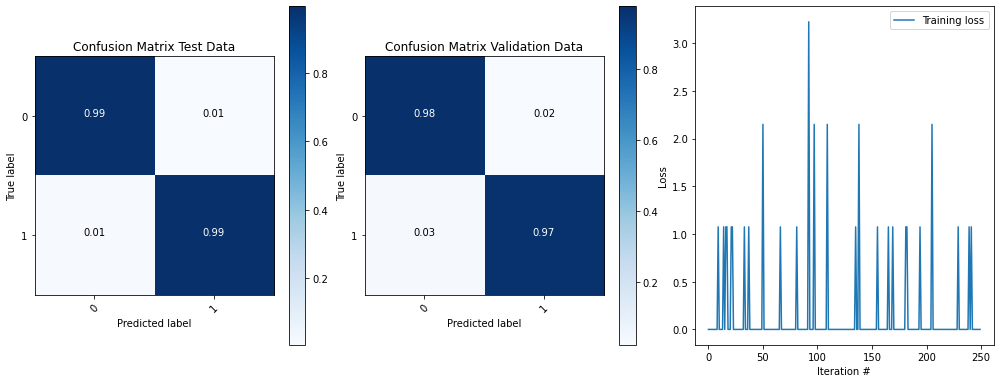

In [25]:
plt.figure(1, figsize=(14,5))

# Prediction
test_labels = model.predict(w, X_test1)

ACC1 = model.accuracy(y_test1[:,-1], test_labels[:,None].flatten())
print('Classification accuracy test set: %.3f%%' % (ACC1.mean(0)))

plt.subplot(1,3,1)
plot_confusion_matrix(model.M, classes=np.arange(2), normalize=True, title="Confusion Matrix Test Data")

test_labels = model.predict(model.params, X_val)

ACC2 = model.accuracy(y_val, test_labels)
print('Classification accuracy validation set: %.3f%%' % (ACC2.mean(0)))
plt.subplot(1,3,2)
plot_confusion_matrix(model.M, classes=np.arange(2), normalize=True,title="Confusion Matrix Validation Data")

# Plotting
plt.subplot(1,3,3)
plt.plot(model.loss_log, label = 'Training loss')

plt.legend()
plt.xlabel('Iteration #')
plt.ylabel('Loss')
plt.show()

# PROBLEM 3


We start by defining the new Linear Regression class for this problem.

In [59]:
from tqdm.notebook import trange, tqdm


class LinearRegression():
  def __init__(self, P_X, y, rng_key):
    self.P_Xmean, self.P_Xstd = P_X.mean(0), P_X.std(0)
    self.Ymean, self.Ystd = y.mean(0), y.std(0)

    P_X = (P_X - self.P_Xmean)/(self.P_Xstd + 10**-8)
    y = (y - self.Ymean)/self.Ystd
    self.P_X = P_X
    self.y = y

    self.dim = P_X.shape[1]
    self.N = P_X.shape[0]
    self.init, self.apply = self.init_linear_regression(self.dim)
    self.params = self.init(rng_key)
    self.opt_init, self.opt_update, self.get_params = optimizers.adam(1e-3)
    self.opt_state = self.opt_init(self.params)
    self.loss_log = []
    self.itercount = itertools.count()


  def init_linear_regression(self, dim):
    def _init(rng_key):
      weights = 0.1*random.normal(rng_key, (dim,))
      logalpha = 5.0 
      logbeta = 0.1
      precisions = np.array([logalpha, logbeta])
      params = weights, precisions
      return params
    def _apply(params, input):
      w, precisions = params
      out = np.dot(input, w)
      return out
    return _init, _apply


  def per_example_loglikelihood(self, params, batch):
    P_X, y = batch
    y_pred = self.apply(params, P_X)
    w, precisions = params
    alpha = np.exp(precisions[0])
    beta = np.exp(precisions[1])
    a1 = self.N / 2 * np.log(2*np.pi/alpha) 
    a2 = self.N / 2 * np.log(2*np.pi/beta) 
    a3 = alpha / 2 * np.matmul((y - y_pred).T, (y-y_pred))
    a4 = beta / 2 * np.matmul(w.T, w) 
    loss = a1 + a2 + a3 + a4
    return loss


  def loss(self, params, batch):
    pe_loss = lambda x: self.per_example_loglikelihood(params, x)
    loss = np.mean(vmap(pe_loss)(batch))
    return loss


  @partial(jit, static_argnums=(0,))
  def step(self, i, opt_state, batch):
    params = self.get_params(opt_state)
    g = grad(self.loss)(params, batch)
    params = self.opt_update(i, g, opt_state)
    return params

  def data_stream(self, n, num_batches, batch_size):
    rng = npr.RandomState(0)
    while True:
      perm = rng.permutation(n)
      for i in range(num_batches):
        batch_idx = perm[i*batch_size:(i+1)*batch_size]
        yield self.P_X[batch_idx, :], self.y[batch_idx]

  def train(self, num_epochs = 100, batch_size = 64):   
    n = self.P_X.shape[0]
    num_complete_batches, leftover = divmod(n, batch_size)
    num_batches = num_complete_batches + bool(leftover) 
    batches = self.data_stream(n, num_batches, batch_size)
    params = self.params
    pbar = trange(num_epochs)
    for epoch in pbar:
      for _ in range(num_batches):
        batch = next(batches)
        self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
      self.params = self.get_params(self.opt_state)
      loss_value = self.loss(self.params, batch)
      self.loss_log.append(np.abs(loss_value))
      pbar.set_postfix({'Loss': loss_value})

  def predict(self, params, X_star):
    X_star = (X_star - self.P_Xmean)/(self.P_Xstd) 
    pred_fn = lambda x: self.apply(params, x)
    y_pred = vmap(pred_fn)(X_star)
    y_pred = y_pred*self.Ystd + self.Ymean
    return y_pred

  def fit_MAP(self, p_of_X): 
      weights, precisions = self.params
      alpha = np.exp(precisions[0])
      beta = np.exp(precisions[1])
      Lambda = np.matmul(p_of_X.T, p_of_X) + \
               (beta/alpha)*np.eye(p_of_X.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      pxTy = np.matmul(p_of_X.T, self.y)
      mu = np.matmul(Lambda_inv, pxTy)      
      return mu, Lambda_inv

  def predictive_distribution(self, w_MAP, Lambda_inv, X_star):
      weights, precisions = self.params
      alpha = np.exp(precisions[0])
      beta = np.exp(precisions[1]) 

      mean_star = np.matmul(X_star, w_MAP)
      var_star = 1.0/alpha + \
                 np.matmul(X_star, np.matmul(Lambda_inv, X_star.T))
      return mean_star, var_star


Define function and dataset generation function

In [60]:
def f(x):
  y = np.sin(2 * np.pi * x) + np.sin(3 * np.pi * x) +  np.sin(4 * np.pi * x) 
  return y

def create_data_Set(N, rng_key):
  X = random.uniform(rng_key, (N, 1), minval = 0 , maxval = 1)
  y = vmap(f)(X)
  noise = 0.2
  y = y + noise*y.std(0)*random.normal(rng_key, y.shape)
  return X, y

Define Fourier basis generation function

In [61]:
def fourierBasis(X, M):
  out = np.zeros((1, len(X)))
  out = np.vstack((out, np.ones((1,len(X)))))
  for i in range(1,M):
    out = np.vstack((out, np.sin(i*np.pi*X)))
    out = np.vstack((out, np.cos(i*np.pi*X)))
  return out.T

Train model to find the optimal parameters from the gradient descent method.

In [62]:
rng_key = random.PRNGKey(0)
X, y = create_data_Set(200, rng_key)
phi = fourierBasis(X.flatten(), 8)
model = LinearRegression(phi, y, rng_key)
model.train(num_epochs = 1000, batch_size = 64)

opt_params = model.params
weights, precisions = opt_params


Generate loss plots (absolute value) for the Regression algorithm using different batch sizes. 

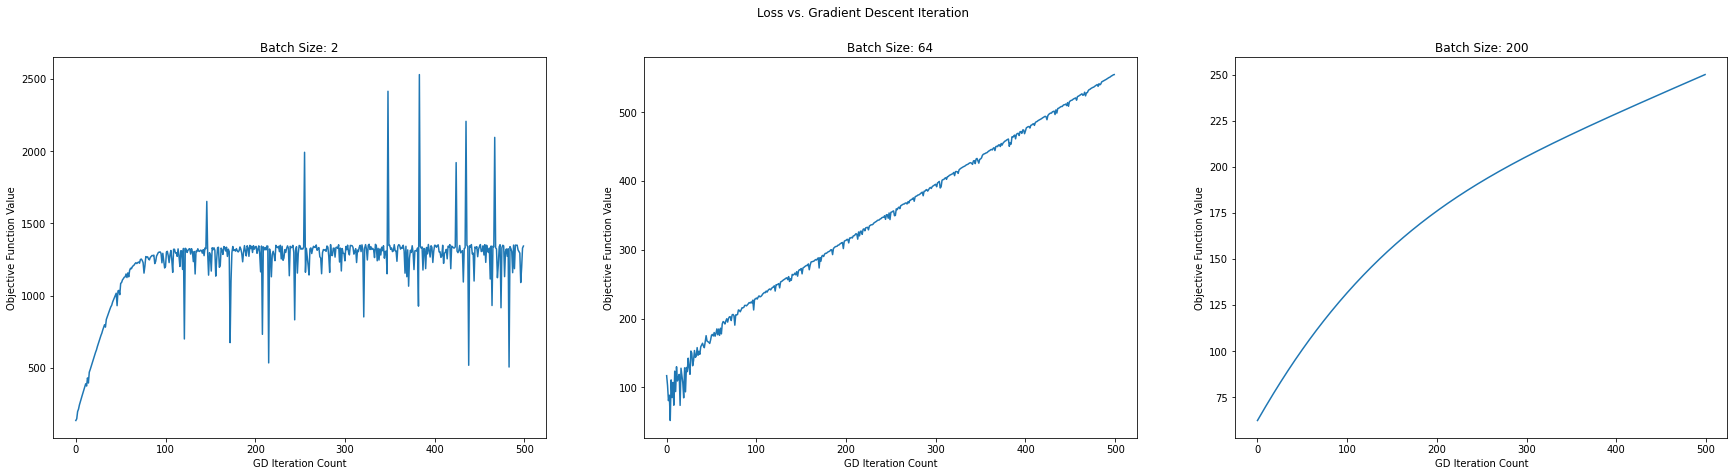

In [63]:
BS = np.array([2, 64, 200]) 

rng_key = random.PRNGKey(0)
X, y = create_data_Set(200, rng_key)

fig, fig2 = plt.subplots(1, 3, figsize = (30,7))
fig.suptitle('Loss vs. Gradient Descent Iteration')


for i in range(len(BS)):

  phi = fourierBasis(X.flatten(), 8)
  model = LinearRegression(phi, y, rng_key)
  model.train(num_epochs = 500, batch_size = BS[i])

  weights, precisions = model.params
  # fig = plt.figure()
  # ax = fig.add_subplot(3,1,i+1)
  fig2[i].plot(model.loss_log)
  fig2[i].set_title('Batch Size: {}'.format(BS[i]));
  fig2[i].set_xlabel("GD Iteration Count")
  fig2[i].set_ylabel("Objective Function Value")


Define the function that you had from the previous week.

In [64]:
from scipy.stats import multivariate_normal, norm
import numpy as onp
class BayesianLinearRegression:
  """
    Linear regression model: y = (w.T)*x + \epsilon
    w ~ N(0,beta^(-1)I)
    P(y|x,w) ~ N(y|(w.T)*x,alpha^(-1)I)
  """

  def __init__(self, X, y, alpha = 1.0, beta = 1.0):
      self.X = X
      self.y = y
      self.alpha = alpha
      self.beta = beta
      self.jitter = 1e-8
      
  def fit_MAP(self, p_of_X): 
      Lambda = np.matmul(p_of_X.T, p_of_X) + \
               (self.beta/self.alpha)*np.eye(p_of_X.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      pxTy = np.matmul(p_of_X.T, self.y)
      mu = np.matmul(Lambda_inv, pxTy)
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      
      return mu, Lambda_inv
      
  def predictive_distribution(self, w_MAP, Lambda_inv, X_star):
      mean_star = np.matmul(X_star, w_MAP)
      var_star = 1.0/self.alpha + \
                 np.matmul(X_star, np.matmul(Lambda_inv, X_star.T))
      return mean_star, var_star


Find the optimal parameters for MAP using the code from las week. 

In [67]:
M = 8
rng_key = random.PRNGKey(0)
X, y = create_data_Set(200, rng_key)
phi = fourierBasis(X.flatten(), M)

alpha = 5
beta = 0.1

m = BayesianLinearRegression(X, y, alpha, beta)
w_MAP, Lambda_inv = m.fit_MAP(phi)
X_star = np.linspace(0,1,200)[:,None] 
y_pred_MAP = np.matmul(fourierBasis(X_star.flatten(), M), w_MAP)

print("Bayesian Linear Regression Weights")
print(w_MAP.flatten())

model = LinearRegression(phi, y, rng_key)
model.train(num_epochs = 1000, batch_size = 64)
params = model.params
y_pred_LR = model.predict(params, fourierBasis(X_star.flatten(), M))
w_MAP_LR, Lambda_inv_MAP_LR = model.fit_MAP(phi)

print("Linear Regression with Gradient Descent Weights")
print(w_MAP_LR.flatten())


# Draw sampes from the predictive posterior
num_samples = 500

mean_star_MAP, var_star_MAP = m.predictive_distribution(w_MAP, Lambda_inv, fourierBasis(X_star.flatten(), M))
samples_MAP = onp.random.multivariate_normal(mean_star_MAP.flatten(), var_star_MAP, num_samples)

mean_star_MAP_LR, var_star_MAP_LR = m.predictive_distribution(w_MAP_LR, Lambda_inv_MAP_LR, fourierBasis(X_star.flatten(), M))
samples_MAP_LR = onp.random.multivariate_normal(mean_star_MAP_LR.flatten(), var_star_MAP_LR, num_samples)



Bayesian Linear Regression Weights
[ 0.          0.06628418  0.00500488 -0.25915527  0.8352051   0.27511597
  0.5734253  -0.31713867  1.1538086  -0.35717773  0.17590332 -0.07797241
  0.14605713  0.04095459  0.0029335   0.07189178]



Linear Regression with Gradient Descent Weights
[ 0.         -0.02856445 -0.06518555 -0.6347656   1.1542969   0.25183105
  0.5109863  -0.36767578  1.5583496  -0.40478516  0.22033691  0.43182373
 -0.16151428  0.06634521 -0.00553894 -0.01998138]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: covariance is not positive-semidefinite.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: covariance is not positive-semidefinite.


(0.0, 1.0)

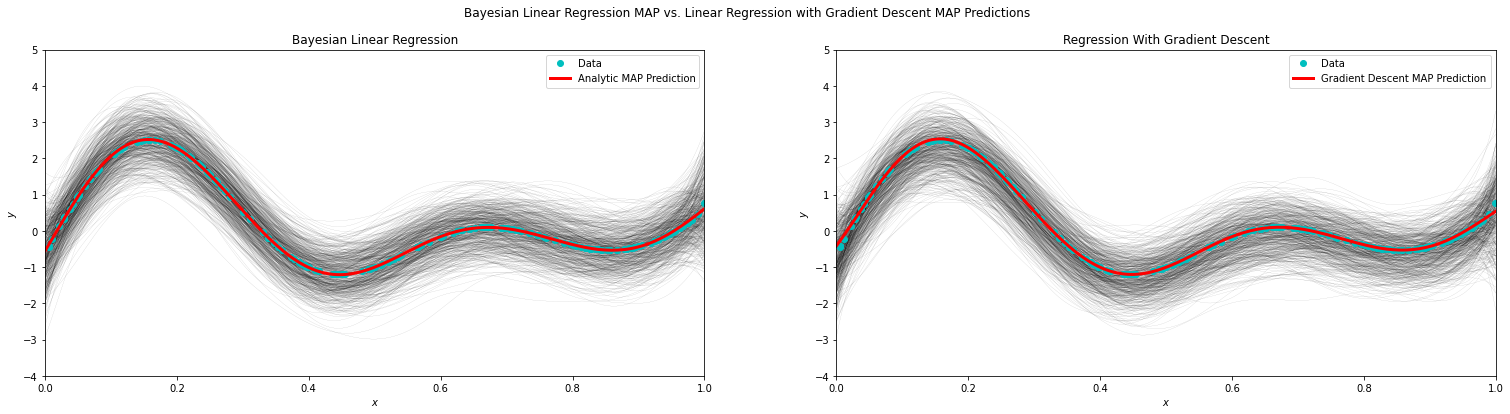

In [68]:
# Plot Results
fig, fig1 = plt.subplots(1,2, figsize = (26,6))
fig.suptitle("Bayesian Linear Regression MAP vs. Linear Regression with Gradient Descent MAP Predictions")

for i in range(0, num_samples):
    fig1[0].plot(X_star, samples_MAP[i,:], 'k', linewidth=0.05)
fig1[0].plot(X,y,'co', label = 'Data')
fig1[0].plot(X_star, y_pred_MAP, 'r', linewidth=3.0, label = 'Analytic MAP Prediction')
fig1[0].legend()
fig1[0].set_xlabel('$x$')
fig1[0].set_ylabel('$y$')
fig1[0].set_title("Bayesian Linear Regression")
fig1[0].set_ylim([-4, 5])
fig1[0].set_xlim([0,1])

for i in range(0, num_samples):
    fig1[1].plot(X_star, samples_MAP_LR[i,:], 'k', linewidth=0.05)
fig1[1].plot(X,y,'co', label = 'Data')
fig1[1].plot(X_star, y_pred_LR, 'r', linewidth=3.0, label = 'Gradient Descent MAP Prediction')
fig1[1].legend()
fig1[1].set_xlabel('$x$')
fig1[1].set_ylabel('$y$')
fig1[1].set_title("Regression With Gradient Descent")
fig1[1].set_ylim([-4, 5])
fig1[1].set_xlim([0, 1])